# 60-inference-zero-shot
> Using built models for inference

In this notebook, we perform zero-shot classification on our transcripts.  Since at this point in our work, we have access to the CSV files, we will use them directly.  We'll start with one, which can then be expanded upon.

#### Common helpful packages

In [ ]:
#all_no_test
#Data analysis and processing
import pandas as pd
import numpy as np

#ml and dl
from transformers import pipeline
from sklearn.metrics import confusion_matrix

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

# file system and python operations
import glob
import os.path
import re

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Load data
In this section, we're going to use glob to see all available csv files, and then we're just going to pick one to process.  Keep in mind that once you have a *list* of filenames, you can then use a list comprehension or for loop to apply the same operation to the in batch.
#### Filename constants

In [ ]:
# Box prefix (uncomment and use the lower variable if the Box directory on your computer is called "Box Sync")
box_prefix = '~/Box/DSI Documents/'
#box_prefix = '~/Box Sync/DSI Documents/'

# Data filepath
csv_filepath = os.path.expanduser(box_prefix + 'cleaned_data/csv_files')

In [ ]:
# get list of all csvs in directory
all_transcript_csvs_list = glob.glob(csv_filepath + '/*.csv')

# show the names of the first 4
all_transcript_csvs_list[0:4]

['C:\\Users\\bellcs1/Box/DSI Documents/cleaned_data/csv_files\\008-1.csv',
 'C:\\Users\\bellcs1/Box/DSI Documents/cleaned_data/csv_files\\008-2.csv',
 'C:\\Users\\bellcs1/Box/DSI Documents/cleaned_data/csv_files\\008-3.csv',
 'C:\\Users\\bellcs1/Box/DSI Documents/cleaned_data/csv_files\\027-1.csv']

Now, I'm going to use the filename to load _just the first csv_.  This is indicated by index `0`.

In [ ]:
#read the csv
transcript_df = pd.read_csv(all_transcript_csvs_list[0])

#show the first 5 rows
display(transcript_df.head())

#print size
transcript_df.shape

,Unnamed: 0,id,transcript_filepath,wave_filename,speech,start_timestamp,end_timestamp,label,transcriber_id
0,0,008-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,acorn.,00:00:11.00,00:01:29.19,NaN,198
1,1,008-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,and you all did a very nice job ((most of you ...,00:00:11.00,00:01:29.19,PRS,198
2,2,008-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,(now) name has asked a very good question.,00:00:11.00,00:01:29.19,PRS,198
3,3,008-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,does acorns turn tall (okay).,00:00:11.00,00:01:29.19,OTR,198
4,4,008-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,(what) what grows to be tall.,00:00:11.00,00:01:29.19,OTR,198


(170, 9)

## A bit of pre-processing
As you can see in the dataframe above, some of the labels are `NaN`, essentially meaning that they're empty.  Since these don't have labels, we're just going to go ahead and drop these rows from the dataframe.  Then, we'll reset the index (this basically means to renumber the index.  Since we took out some rows, those row indices will be missing.  We want to renumber so that the index has continguous numbering.)

In [ ]:
# drop NA rows
transcript_df = transcript_df.dropna()

# reset the index
# the drop=True argument means that we don't make the old index a new column in our dataframe
transcript_df = transcript_df.reset_index(drop=True)

# Add a column named sample_id with the reset_index trick
transcript_df = transcript_df.reset_index().rename(columns={'index':'sample_id'})

# see the new size
print(transcript_df.shape)

(163, 9)


After processing, we can see that there were 7 unlabeled examples in this dataset, which have been removed.  Let's take another look just to make sure everything looks good:

In [ ]:
transcript_df.head(3)

,sample_id,id,transcript_filepath,wave_filename,speech,start_timestamp,end_timestamp,label,transcriber_id
0,0,008-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,and you all did a very nice job ((most of you ...,00:00:11.00,00:01:29.19,PRS,198
1,1,008-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,(now) name has asked a very good question.,00:00:11.00,00:01:29.19,PRS,198
2,2,008-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,does acorns turn tall (okay).,00:00:11.00,00:01:29.19,OTR,198


Great.

# Zero-shot classification
Now, we're going to actually perform the zero-shot classification using the text from above.  We'll first declare some parameters and create the zero-shot pipeline for easy modification of the labels and model type.

In [ ]:
# these are the labels that were added to the transcripts (don't change these or the order)
transcript_labels = ['PRS', 'REP', 'NEU', 'OTR']

# define list of candidate labels (change these, but not the order)
candidate_labels = ["praise", "reprimand", "neutral", "opportunity to respond"]

# define and create pipeline
classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli')

Now, we're going to build a dictionary of correspondences using the labels above (which is why we don't change the order).  If you do change the order, just know that the position in one set of labels must have its match at the same position in the other labels.  See below.

We'll use this later to match between our names for the labels (`candidate_labels`) and the transcript labels (`transcript_labels`).

In [ ]:
labels_lookup = dict(zip(candidate_labels, transcript_labels))
labels_lookup

{'praise': 'PRS',
 'reprimand': 'REP',
 'neutral': 'NEU',
 'opportunity to respond': 'OTR'}

In [ ]:
rev_labels_lookup = dict(zip(transcript_labels, candidate_labels))
rev_labels_lookup

{'PRS': 'praise',
 'REP': 'reprimand',
 'NEU': 'neutral',
 'OTR': 'opportunity to respond'}

## Make predictions on one cleaned transcript
Now, we'll then use the `speech` column of `transcript_df` to provide inputs to the classifier in batch, and get the results in batch.

In [ ]:
# Get all the rows of text in the speech column, and convert the data structure into a list.  Use this as the sequences (text) argument to the classifier
# Use the candidate_labels variable we defined above, and use that as the candidate_labels ARGUMENT to the classifier
results_list = classifier(sequences = transcript_df['speech'].tolist(),
                          candidate_labels = candidate_labels)

## Convert to a reasonable representation
The results returned are a list of dictionaries.  Each dictionary contains the sequence, the labels, and the probabilities associated with each label.  This will be shown below.  Dictionaries are easily converted to pandas dataframes, where each key becomes a column of the new dataframe.  In the same way, lists of dictionaries are also easily converted to pandas dataframes.

In [ ]:
#look at the first 2 elements of results_list
results_list[:2]

[{'sequence': 'and you all did a very nice job ((most of you anyway)) passing the acorns around.',
  'labels': ['praise', 'opportunity to respond', 'neutral', 'reprimand'],
  'scores': [0.8971229195594788,
   0.0798172876238823,
   0.017446404322981834,
   0.00561338709667325]},
 {'sequence': '(now) name has asked a very good question.',
  'labels': ['opportunity to respond', 'praise', 'neutral', 'reprimand'],
  'scores': [0.5795802474021912,
   0.348969966173172,
   0.04134771600365639,
   0.030102074146270752]}]

In [ ]:
#example of converting a single element of this list to a dataframe
pd.DataFrame(results_list[0])

,sequence,labels,scores
0,and you all did a very nice job ((most of you ...,praise,0.897123
1,and you all did a very nice job ((most of you ...,opportunity to respond,0.079817
2,and you all did a very nice job ((most of you ...,neutral,0.017446
3,and you all did a very nice job ((most of you ...,reprimand,0.005613


In [ ]:
#use a list comprehension to generate a list of these dataframes
results_df_list = [pd.DataFrame(result) for result in results_list]

#add the sample_id column for each dataframe
results_df_list = [df.assign(sample_id = ind) for ind, df in enumerate(results_df_list)]

#concatenate this list together to form one single dataframe
results_df = pd.concat(results_df_list)
results_df.head()

,sequence,labels,scores,sample_id
0,and you all did a very nice job ((most of you ...,praise,0.897123,0
1,and you all did a very nice job ((most of you ...,opportunity to respond,0.079817,0
2,and you all did a very nice job ((most of you ...,neutral,0.017446,0
3,and you all did a very nice job ((most of you ...,reprimand,0.005613,0
0,(now) name has asked a very good question.,opportunity to respond,0.579580,1


In [ ]:
#pivot_wider and take `sequence` off the index
results_df = results_df.pivot(index=['sample_id', 'sequence'], columns='labels', values='scores').reset_index(level='sequence')
results_df

labels,sequence,neutral,opportunity to respond,praise,reprimand
sample_id,,,,,
0,and you all did a very nice job ((most of you ...,0.017446,0.079817,0.897123,0.005613
1,(now) name has asked a very good question.,0.041348,0.579580,0.348970,0.030102
2,does acorns turn tall (okay).,0.184080,0.541341,0.241106,0.033473
3,(what) what grows to be tall.,0.101838,0.699977,0.137719,0.060466
4,(what) the what?,0.125086,0.700275,0.053163,0.121476
...,...,...,...,...,...
158,water is very important for plants to grow.,0.090706,0.653119,0.103231,0.152944
159,(okay) let's listen to the poem.,0.061167,0.810983,0.096549,0.031302
160,to the>,0.073823,0.599837,0.204093,0.122246


In [ ]:
#get the max of the labels columns (using candidate_labels) and add a column called 'pred_zslabels'
results_df['pred_zslabels'] = results_df[candidate_labels].idxmax(axis=1)

#now we'll use the lookup dictionary we made above to create the pred column to correspond to the real labels
results_df['pred'] = results_df['pred_zslabels'].replace(labels_lookup)

In [ ]:
#now, we'll join on the real labels and some other columns just to make sure things look right
results_df = results_df.merge(transcript_df[['sample_id', 'label', 'speech']], left_index=True, right_on='sample_id')

#there's a current challenge in the data with leading and trailing whitespace so let's make sure to strip that off our labels
results_df['label'] = results_df['label'].str.strip()

#let's rename the 'label' column to be 'truth'
results_df = results_df.rename(columns={'label':'truth'})

#let's look at the first 15 rows of the result
results_df.head(15)

,sequence,neutral,opportunity to respond,praise,reprimand,pred_zslabels,pred,sample_id,truth,speech
0,and you all did a very nice job ((most of you ...,0.017446,0.079817,0.897123,0.005613,praise,PRS,0,PRS,and you all did a very nice job ((most of you ...
1,(now) name has asked a very good question.,0.041348,0.579580,0.348970,0.030102,opportunity to respond,OTR,1,PRS,(now) name has asked a very good question.
2,does acorns turn tall (okay).,0.184080,0.541341,0.241106,0.033473,opportunity to respond,OTR,2,OTR,does acorns turn tall (okay).
3,(what) what grows to be tall.,0.101838,0.699977,0.137719,0.060466,opportunity to respond,OTR,3,OTR,(what) what grows to be tall.
4,(what) the what?,0.125086,0.700275,0.053163,0.121476,opportunity to respond,OTR,4,OTR,(what) the what?
5,the tree (okay).,0.259022,0.264859,0.447020,0.029100,praise,PRS,5,NEU,the tree (okay).
6,(so when) the acorn has to go where?,0.019786,0.852068,0.039393,0.088753,opportunity to respond,OTR,6,OTR,(so when) the acorn has to go where?
7,in the what for the tree to grow?,0.020878,0.932906,0.032221,0.013995,opportunity to respond,OTR,7,OTR,in the what for the tree to grow?
8,in the what?,0.151333,0.674712,0.063011,0.110944,opportunity to respond,OTR,8,OTR,in the what?
9,(the in the) not the grass.,0.345485,0.302016,0.120586,0.231913,neutral,NEU,9,NEU,(the in the) not the grass.


Great! This looks correct.  Let's start with the performance evaluation.

## Evaluate performance using confusion matrix
Given the structure our results, let's finish up with a confusion matrix.

In [ ]:
#use confusion matrix function from scikit-learn metrics
c_ma = confusion_matrix(results_df.dropna()['truth'], results_df.dropna()['pred'], labels=transcript_labels)

In [ ]:
#create a dataframe from the confusion matrix
c_df = pd.DataFrame(c_ma,
                    columns = transcript_labels,
                    index = transcript_labels)

#use reverse lookup table from above to use the actual labels that we assigned for zero shot
c_df.rename(columns=rev_labels_lookup, index=rev_labels_lookup, inplace=True)

#add axis labels for seaborn
c_df.index.name = 'Actual Labels'
c_df.columns.name = 'Predicted Labels'

#inspect
c_df

Predicted Labels,praise,reprimand,neutral,opportunity to respond
Actual Labels,,,,
praise,17,0,0,3
reprimand,0,0,0,0
neutral,8,1,12,72
opportunity to respond,1,0,0,49


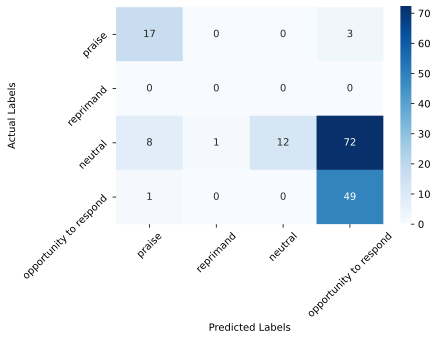

In [ ]:
#use seaborne to display as heatmap
ax = sns.heatmap(c_df, cmap='Blues', annot=True);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);
ax.set_yticklabels(ax.get_yticklabels(),rotation = 45);

Let's inspect this confusion matrix.
* First, we can see that there are no reprimand labels in this transcript.  
* It is hard for zero shot to distinguish neutral.  Looking across the row, neutral is incorrectly predicted to be every class, but ESPECIALLY opportunity to respond.
* The model is great at classifying opportunity to respond (high sensitivity), but that's mostly because it seems to think EVERYTHING is an opportunity to respond (e.g., low precision.  It predicts 124 out of the 163 examples to be opportunity to respond (to be fair, correctly classifying 49 of them).

Great steps to improve from here include:
* Employing different labels
* Using different models
* Inspecting the eyeball set of misclassified samples to identify if there's any similarities or improvements which can be proposed.

### Quick sanity checks
Here, we'll just do a few quick sanity checks to make sure things look right

In [ ]:
#this should be the total number of rows in the results and transcripts dataframe (after dropping NAs)
c_df.sum().sum() #passed

163

In [ ]:
#this should be equal to the sum of the rows of the confusion matrix
results_df['truth'].value_counts() #passed

NEU    93
OTR    50
PRS    20
Name: truth, dtype: int64

We can also see that there are twice as many `neutral` are there are `opportunity to respond`, and twice as many `opportunity to respond` as there are `positive`.

In [ ]:
#this should be equal to the sum of the columns of the confusion matrix
results_df['pred'].value_counts() #passed

OTR    124
PRS     26
NEU     12
REP      1
Name: pred, dtype: int64